# Cats and Dogs Classification with CNN


In this notebook, we'll build a Convolutional Neural Network (CNN) to classify cats and dogs using **PyTorch**.


We will use the **Cat and Dog** dataset from Kaggle, which contains 10,028 RGB images: 8,005 for training (4,000 cats + 4,005 dogs) and 2,023 for testing (1,011 cats + 1,012 dogs), along with 4 _DS_Store files that will be automatically ignored by ImageFolder during loading. The images have different sizes, so some preprocessing will be necessary.

First, the needed imports. If you are using Colab, it provides a pre-configured PyTorch environment, so we just need to import the relevant packages.

In [ ]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

import numpy as np
import matplotlib.pyplot as plt
import os

print('Using PyTorch version:', torch.__version__)
if torch.cuda.is_available():
    print('Using GPU, device name:', torch.cuda.get_device_name(0))
    device = torch.device('cuda')
else:
    print('No GPU found, using CPU instead.')
    device = torch.device('cpu')

Using PyTorch version: 2.5.1+cu121
Using GPU, device name: Tesla T4


# Load and Augment the Dataset

We can download and load the **Cat and Dog** dataset from kagglehub. This will be downloaded to the .cache folder. If you are using Colab, it corresponds to the /root/.cache folder, which is a temporary storage space, so you will need to re-download it every time you reconnect. If you are using a local environment, it corresponds to the /username/.cache folder, which only requires a one-time download but will take approximately 237MB memory space.

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tongpython/cat-and-dog")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/tongpython/cat-and-dog/versions/1


In [ ]:
# If download succcesfully, this should output 1012
files = os.listdir(path+"/test_set/test_set/cats")
print(f"Files number: {len(files)}")

Files number: 1012


Now we are ready to load the data, but before that, we need to preprocess the images, including data augmentation. The preprocessing here is mainly about image resizing to ensure consistent image size and using `ToTensor` to convert pixels to the range [0,1].

**Offline data augmentation**: Image data augmentation is a technique that can be used to artificially expand the size of a training dataset by creating modified versions of images in the dataset. Usually the augmentation is performed on the training set only.


![alt text](https://cdn-images-1.medium.com/max/1000/1*C8hNiOqur4OJyEZmC7OnzQ.png)


As an example, we will use horizontal flipping and rotation here. You are free to explore more augmentation operations.

In [ ]:
image_size = 128

# Data augmentation and preprocessing
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # random horizontal flip
    transforms.RandomRotation(degrees=15),  # random rotation up to 15 degree
    transforms.Resize((image_size, image_size)),  # Image Resize
    transforms.ToTensor(),  # converts [0,255] range to [0,1]
])

transform_test = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # Image Resize
    transforms.ToTensor(),  # converts [0,255] range to [0,1]
])

# Load dataset from local folders
train_dataset = datasets.ImageFolder(root=path+"/training_set/training_set", transform=transform_train)
test_val_dataset = datasets.ImageFolder(root=path+"/test_set/test_set", transform=transform_test)

# split validation set (25%) and test set (75%) from the original test_set
total_size = len(test_val_dataset)
val_size = total_size // 4
test_size = total_size - val_size

test_dataset, val_dataset = random_split(test_val_dataset, [test_size, val_size])


# Define data loaders to feed the data to the model during training and testing
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset,  batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

# check the data information
print(f"Classes: {train_dataset.classes}")  # output: ['cats', 'dogs']
print(f"Classes index: {train_dataset.class_to_idx}") # output: {'cats': 0, 'dogs': 1}
print("Number of training samples:", len(train_dataset))
print("Number of val samples:", len(val_dataset))
print("Number of test samples:", len(test_dataset))


Classes: ['cats', 'dogs']
Classes index: {'cats': 0, 'dogs': 1}
Number of training samples: 8005
Number of val samples: 505
Number of test samples: 1518


The data loaders provide a way of iterating (making a loop over) the datasets, each time getting a new batch of data with the given batch size.

The first element of the data batch (`data`) is a 4th-order tensor of size (`batch_size`, 3, `image_size`, `image_size`), i.e. assuming `image_size` is 128, it consists of a batch of images of size 3x128x128 pixels, where the first value is the number of color channels.

The second element of the batch (`target`) is a vector containing the correct (or "target") classes ("0" or "1") for cats or dogs.

In [ ]:
for (data, target) in train_loader:
    print('data:', data.size(), 'type:', data.type())
    print('target:', target.size(), 'type:', target.type())
    break

data: torch.Size([32, 3, 128, 128]) type: torch.FloatTensor
target: torch.Size([32]) type: torch.LongTensor


# Visualize Some Sample Images
Let's visualize the first six images from the training set:

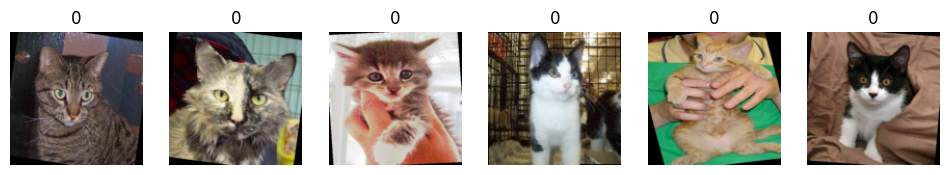

In [ ]:
fig = plt.figure(figsize=(12, 2))
for i in range(6):
    image, label = train_dataset[i]
    ax = fig.add_subplot(1, 6, i+1)
    ax.imshow(image.permute(1, 2, 0)) # convert dimentions to adapt Matplotlib
    ax.set_title(str(label))
    ax.axis('off')
plt.show()


# Building the CNN Model in PyTorch

In PyTorch, a neural network is defined as a Python class. It needs to have two methods:

- `__init__()` which initializes the layers used in the network
- `forward()` which defines how the network performs a forward pass

PyTorch will then automatically generate a `backward()` method that computes the gradients based on the computation done in the forward pass.

All the [neural network building blocks defined in PyTorch can be found in the torch.nn documentation](https://pytorch.org/docs/stable/nn.html).

Here is the structure we used as a baseline:
* Two convolutional layers (32 and 64 filters, each 3×3 kernel with padding=1), each followed by 2×2 max pooling.
* A fully connected hidden layer (nn.Linear) with 64 units and ReLU activation.
* A final fully connected layer of size 2 for the 2 classes (Cat and Dog).
* We typically apply the softmax implicitly through CrossEntropyLoss.



In [ ]:
class CatDogCNN(nn.Module):
    def __init__(self):
        super(CatDogCNN, self).__init__()

        # Extract features with conv layers
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),  # Conv Layer 1
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Max Pooling 1

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),  # Conv Layer 2
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)   # Max Pooling 2
        )

        # Fully connected layers
        self.classifier = nn.Sequential(
            nn.Linear(64 * 32 * 32, 64),  # Adjusted for 128x128 input
            nn.ReLU(),
            nn.Linear(64, 2)  # Output layer for 2 classes
        )

    def forward(self, x):
        # Pass through convolutional layers
        x = self.features(x)
        # Flatten the tensor
        x = torch.flatten(x, start_dim=1)
        # Pass through fully connected layers
        x = self.classifier(x)
        return x

model = CatDogCNN().to(device)

# Print summary

In [ ]:
print(model)

CatDogCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=65536, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=2, bias=True)
  )
)


# Define the Loss Function and Optimizer

Same as the previous lab, we need to define a loss function and an optimizer.

For a classification task we typically use the cross entropy loss. For this we can use the class [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

Also, we need to define an optimizer, which tells how to update the model parameters based on the computed gradients. There are [several different optimizer algorithms implemented in PyTorch](https://pytorch.org/docs/stable/optim.html#algorithms).

In [ ]:
criterion = nn.CrossEntropyLoss()  # combines softmax + cross entropy
optimizer = optim.Adam(model.parameters())

# Training the Model

After the previous lab, you should be familiar with defining the training process.

Here, we train the model for 20 epochs. During each epoch, we:

1. Set the model to training mode (model.train()).
2.  Loop over the train_loader, compute the loss, do backpropagation, and update parameters.
3. Evaluate on the test set (used here as the validation set, as in your original example).
4. Track the best validation accuracy and save the model weights (model.weights.best.hdf5) whenever we see an improvement.

First, a helper function to calculate the number of correctly classified samples.

In [ ]:
def correct(output, target):
    predicted_digits = output.argmax(1)                # pick digit with largest network output
    correct_ones = (predicted_digits == target).type(torch.float)  # 1.0 for correct, 0.0 for incorrect
    return correct_ones.sum().item()                  # count number of correct ones


In [ ]:
epochs = 20
best_acc = 0.0
train_loss = []
val_loss = []
train_acc = []
val_acc = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    running_acc = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # 1. Zero the gradients
        optimizer.zero_grad()

        # 2. Forward pass
        outputs = model(images)

        # 3. Compute the loss
        loss = criterion(outputs, labels)

        # 4. Backpropagation
        loss.backward()

        # 5. Update parameters
        optimizer.step()

        # Accumulate the training loss and accuracy
        running_loss += loss.item() * images.size(0)
        running_acc += correct(outputs, labels)

    # Compute average training loss and accuracy over an epoch
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100.0 * running_acc / len(train_loader.dataset)

    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)

    # Evaluate on the test set
    model.eval()
    val_correct = 0
    val_loss_count = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss_count += loss.item() * images.size(0)
            val_correct += correct(outputs,labels)

    val_loss_epoch = val_loss_count / len(val_loader.dataset)
    val_acc_epoch = 100.0 * val_correct / len(val_loader.dataset)

    val_loss.append(val_loss_epoch)
    val_acc.append(val_acc_epoch)

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%, Test Accuracy: {val_acc_epoch:.2f}%")

    # Save the model if the test accuracy is the best we've seen so far
    if val_acc_epoch > best_acc:
        best_acc = val_acc_epoch
        torch.save(model.state_dict(), 'model.weights.best.hdf5')
        print("  --> Model saved.")


Epoch [1/20], Loss: 0.7119, Accuracy: 50.96%, Test Accuracy: 51.29%
  --> Model saved.
Epoch [2/20], Loss: 0.6832, Accuracy: 55.78%, Test Accuracy: 60.00%
  --> Model saved.
Epoch [3/20], Loss: 0.6610, Accuracy: 60.80%, Test Accuracy: 62.97%
  --> Model saved.
Epoch [4/20], Loss: 0.6224, Accuracy: 64.91%, Test Accuracy: 63.76%
  --> Model saved.
Epoch [5/20], Loss: 0.5934, Accuracy: 67.93%, Test Accuracy: 65.35%
  --> Model saved.
Epoch [6/20], Loss: 0.5694, Accuracy: 69.58%, Test Accuracy: 68.71%
  --> Model saved.
Epoch [7/20], Loss: 0.5432, Accuracy: 72.53%, Test Accuracy: 73.47%
  --> Model saved.
Epoch [8/20], Loss: 0.5264, Accuracy: 73.67%, Test Accuracy: 71.49%
Epoch [9/20], Loss: 0.5124, Accuracy: 74.24%, Test Accuracy: 71.88%
Epoch [10/20], Loss: 0.5032, Accuracy: 75.50%, Test Accuracy: 73.27%
Epoch [11/20], Loss: 0.4901, Accuracy: 76.20%, Test Accuracy: 73.86%
  --> Model saved.
Epoch [12/20], Loss: 0.4683, Accuracy: 77.24%, Test Accuracy: 74.26%
  --> Model saved.
Epoch [13/

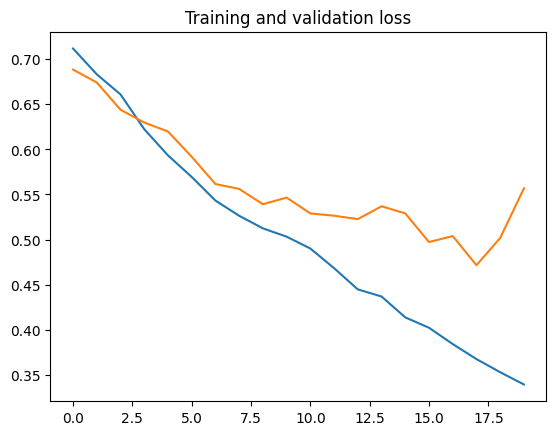

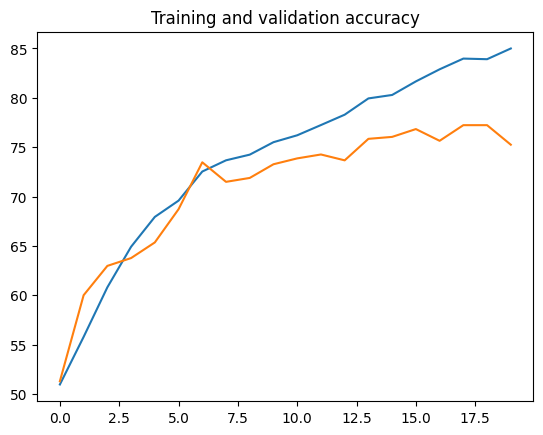

In [ ]:
# plot learning curve
plt.figure()
plt.title('Training and validation loss')
plt.plot(np.arange(0, epochs), train_loss, label="train_loss")
plt.plot(np.arange(0, epochs), val_loss, label="val_loss")

plt.figure()
plt.title('Training and validation accuracy')
plt.plot(np.arange(0, epochs), train_acc, label="train_acc")
plt.plot(np.arange(0, epochs), val_acc, label="val_acc")

# Load the Best Model and Evaluate on the Test Set
Finally, we load the saved weights that gave the highest accuracy on the test set and report our test accuracy again:

In [ ]:
# Load the best saved model
model.load_state_dict(torch.load('model.weights.best.hdf5', weights_only=False))
model.eval()

test_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        test_correct += correct(outputs,labels)

test_accuracy = 100.0 * test_correct / len(test_loader.dataset)
print(f"Best Model Test Accuracy: {test_accuracy:.2f}%")


Best Model Test Accuracy: 76.68%


## Task: Try it yourself

Now, you are free to explore and familiarize with the use of CNN. Remember to use the worksheet.